In [1]:
#Wnioski (błąd - MSE - metryki przeanalizuję na innym neuralu):
# 1) Zwykły SGD - do 0.035, niezależnie od liczby prób - szybki, 150s/10000i
# 2) Momentum - do 0.025, 110.000 prób - szybki, 160s/10000i
# 3) Nestorov - szybciej zbiega(0.028 - 60.000), zajebiście wolny, 240s/10000i
# 4) AdaGrad - zbiega nawet szybciej z lr=0.1 (0.03 - 40.000), później beton nie do ruszenia (sum > 10e5), szybki
# 5) RMSEProp



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist
import setuptools
%load_ext Cython

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

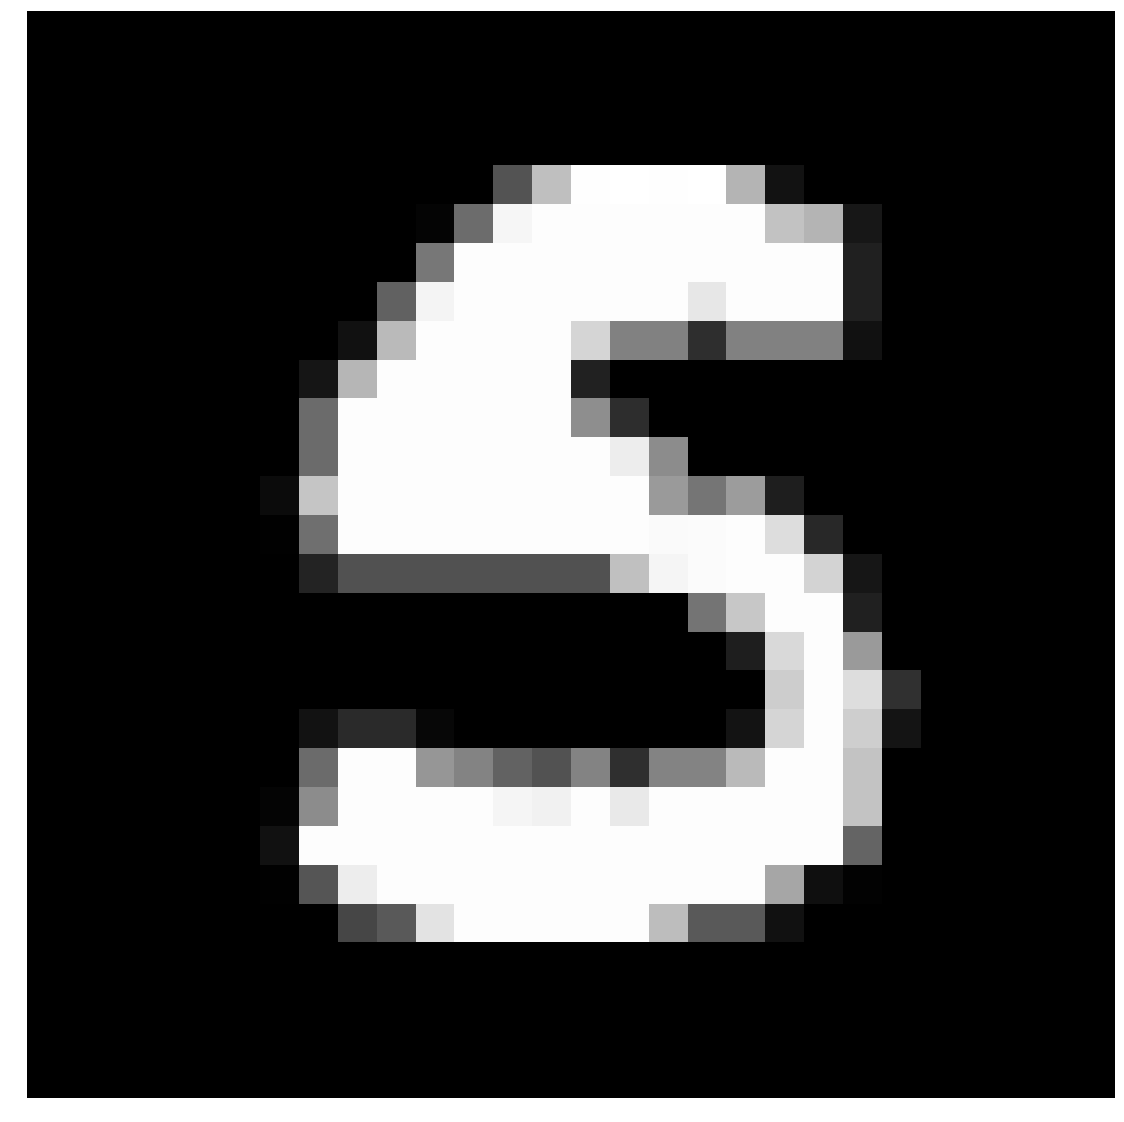

In [2]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

def supdisp(X, ax=None, titel=''):
    charred_bloodbirds_escape_from_the_ruins=0
    if (ax==None):
        charred_bloodbirds_escape_from_the_ruins=1
        fig, ax=plt.subplots(1,1,figsize=(20,20))
    Y=X.copy()
    
    zz1=Y.copy()
    Y=np.append(Y, zz1, axis=2)
    Y=np.append(Y, zz1, axis=2)
    
    ax.imshow(Y)
    ax.set_title(titel)
    ax.axis('off')
    if (charred_bloodbirds_escape_from_the_ruins==1):
        plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [3]:
def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0

def relu_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def relu_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def sigm_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigm_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def tanh_forw(v):
    return np.asmatrix(np.apply_along_axis(math.tanh, 1, v).reshape(v.shape[0], 1))

def tanh_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: (1+math.tanh(x))*(1-math.tanh(x)), 1, v).reshape(v.shape[0], 1))

In [107]:
#Ustawianie parametrów
#Rozdział ustawienia parametrów i neurala - pozwala mi na wznowiecie nauki neurala bez zapisu outów

#Wagi, biasy, delty wag/biasów
w=[0]*10
bw=[0]*10
weight_delta=[0]*10
summerland=[0]*10
bias_delta=[0]*10

#Tymczasowe zmienne do trzymania outów i pochodnych po backpropagosie
act=[0]*10
wact=[0]*10
back_p=[0]*10
#lyrning rejt
nn_delta=0.01
#Funkcje wykonywane przez warstwy, warstwy - logic (bez 1-wszej: input)[rozmiar k-tej warstwy od 1]
lst=28*28
logic=[50,20,50,lst]
fforw=[sigm_forw, sigm_forw, sigm_forw, sigm_forw]
fback=[sigm_back, sigm_back, sigm_back, sigm_back]
momentum=0.9
eps=0.00000001
ll=len(logic)

#Determinacja wag i biasów
for i in range(ll):
    w[i]=np.asmatrix([0.15*np.random.normal(0, 1) for j in range(lst*logic[i])]).reshape(logic[i], lst)
    weight_delta[i]=np.zeros((logic[i], lst))
    summerland[i]=np.zeros((logic[i], lst))
    bw[i]=0.15*np.random.normal(0, 1)
    lst=logic[i]

In [110]:
#Poligon doświadczalny do gradientu i 

#iteracje, epoki, zapis wyniku do wykresu
iterr=10000
epokz=1
aedificator_mundi_carcerem=[0]*(iterr*epokz)

for ii in range(epokz):
    t1=time.time()
    for i in range(iterr):
        img=trainX[i].copy()
        img=img/255
        img=img.reshape(img.shape[0]*img.shape[1],1)

        wact[0]=np.asmatrix(img.copy())
        for j in range(1, ll+1):
            act[j]=w[j-1]*wact[j-1]#+bw[j-1]
            wact[j]=fforw[j-1](act[j])

        ####  Kost
        kgb=np.asarray(img)-np.asarray(wact[ll])
        der=-2*kgb
        kgb=kgb*kgb
        s=(sum(kgb)/len(kgb))
        s=s[0]
        aedificator_mundi_carcerem[iterr*ii+i]=s
        ####

        #kar=np.asarray(wact[ll]).reshape(trainX[i].shape[0], trainX[i].shape[1], 1)
        #supdisp(kar)

        back_p[ll+1]=der
        for j in range(ll,0,-1):
            #sdel=np.multiply(fback[j-1]((w[j-1]-momentum*weight_delta[j-1])*wact[j-1]),back_p[j+1]) ##Nestorov
            #weight_delta[j-1]=momentum*weight_delta[j-1]+nn_delta*(sdel*wact[j-1].T) ##Nestorov
            
            sdel=np.multiply(fback[j-1](act[j]),back_p[j+1])
            
            adder=sdel*wact[j-1].T ##RMSProp+AdaGrad
            #summerland[j-1]=summerland[j-1]+np.multiply(adder, adder) ##AdaGrad
            summerland[j-1]=momentum*summerland[j-1]+(1-momentum)*np.multiply(adder, adder) ##RMSProp
            weight_delta[j-1]=np.multiply((nn_delta/np.sqrt(summerland[j-1]+eps)), adder) ##RMSProp+AdaGrad
            
            #weight_delta[j-1]=momentum*weight_delta[j-1]+nn_delta*(sdel*wact[j-1].T) ##Momentum
            #weight_delta[j-1]=nn_delta*(sdel*wact[j-1].T) ##SGD
            #bias_delta[j-1]=sum(sdel)[0,0]/len(sdel)
            back_p[j]=w[j-1].T*sdel

        for j in range(ll):
            w[j]-=weight_delta[j]
            #bw[j]-=bias_delta[j]*nn_delta
    t2=time.time()
    print(t2-t1)

169.12067317962646


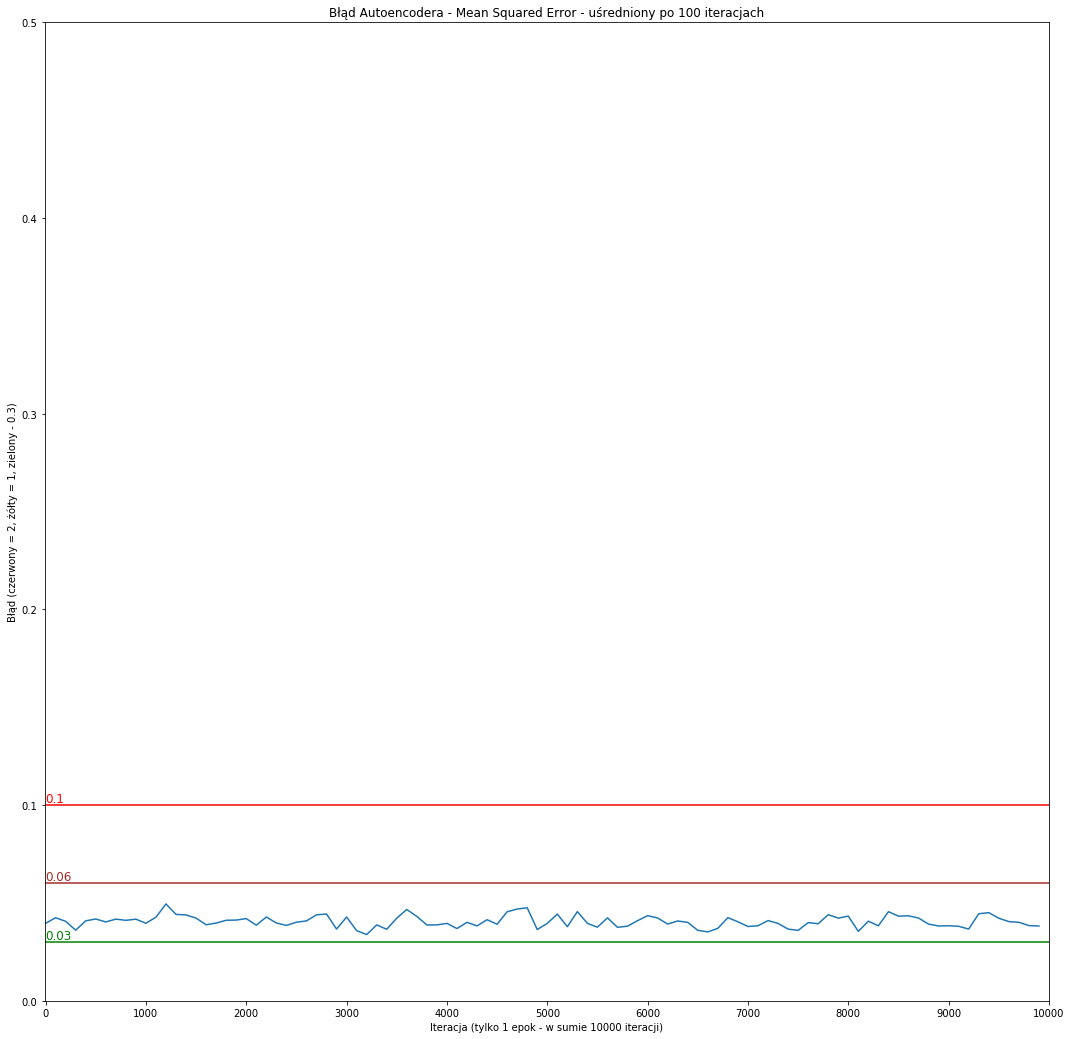

In [111]:
fig, ax=plt.subplots(1, 1, figsize=(18,18))
#dt - liczba iteracji, kgbo - uśrednienie błędu po tylu iteracjach, ss- parametr labeli
dt=iterr*epokz
kgbo=100
dt2=dt//kgbo
ss=10

#Formulacja średnich
dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(aedificator_mundi_carcerem[i*kgbo:(i+1)*kgbo])/kgbo

alpha, beta, gamma=0.1,0.06,0.03

ax.set_title('Błąd Autoencodera - Mean Squared Error - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko {} epok - w sumie {} iteracji)'.format(epokz, dt))
ax.set_xticklabels(range(0, dt+1, kgbo*ss))
ax.set_xticks(range(0, dt//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1, zielony - 0.3)')
ax.axhline(alpha, color='red')
ax.axhline(beta, color='brown')
ax.axhline(gamma, color='green')
ax.plot(dkkk)
ax.text(x=0, y=alpha, s='{}'.format(alpha), verticalalignment='bottom', horizontalalignment='left', color='red', size=12)
ax.text(x=0, y=beta, s='{}'.format(beta), verticalalignment='bottom', horizontalalignment='left', color='brown', size=12)
ax.text(x=0, y=gamma, s='{}'.format(gamma), verticalalignment='bottom', horizontalalignment='left', color='green', size=12)
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.1, dt2)
plt.show()

3.57120418548584


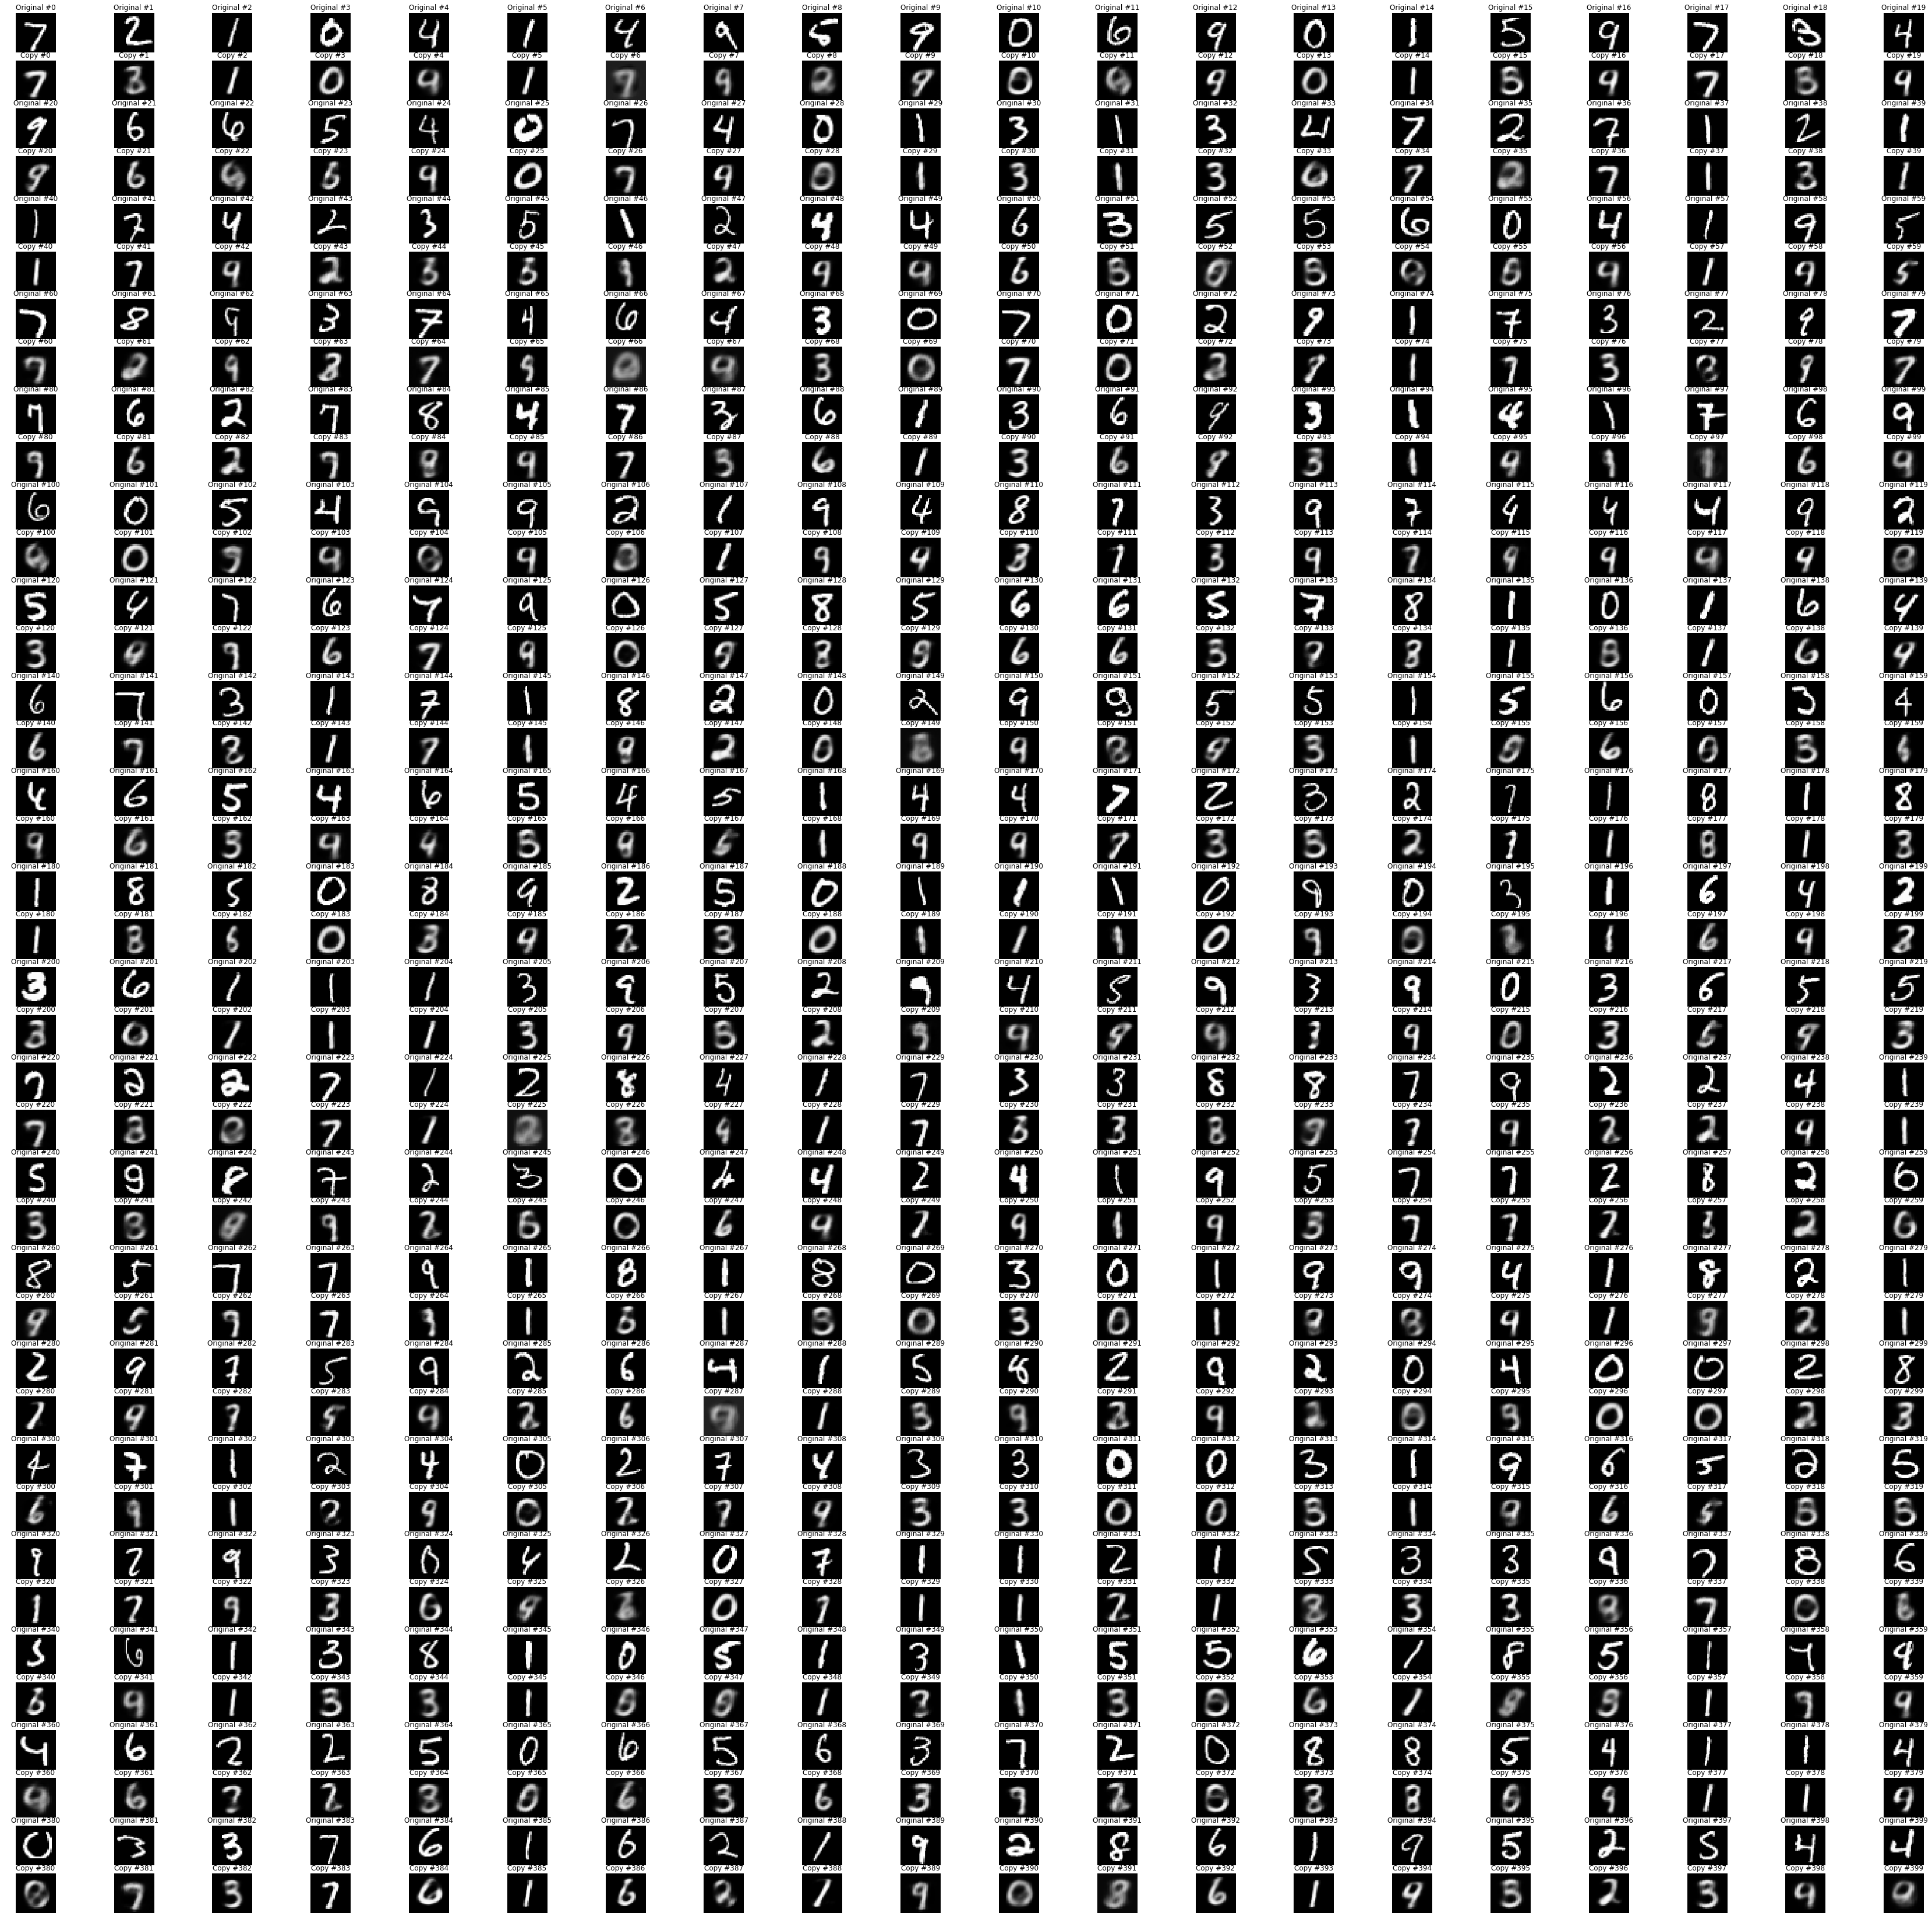

In [112]:
#Wizualifikacja niezwizualizowanego
#Liczba obrazków z testu
iterr=400

act=[0]*10
wact=[0]*10
ggout=[0]*iterr
#Tworze wykres
asqrt=math.ceil(math.sqrt(iterr))
fig, ax=plt.subplots(2*asqrt, asqrt, figsize=(asqrt*3,asqrt*3))

t1=time.time()
for i in range(iterr):
    img=testX[i].copy()
    img=img/255
    img=img.reshape(img.shape[0]*img.shape[1],1)

    wact[0]=np.asmatrix(img.copy())
    for j in range(1, ll+1):
        act[j]=w[j-1]*wact[j-1]#+bw[j-1]
        wact[j]=fforw[j-1](act[j])

    ####  Kost
    kgb=np.asarray(img)-np.asarray(wact[ll])
    kgb=kgb*kgb
    s=(sum(kgb)/len(kgb))
    s=s[0]
    ggout[i]=s
    ####
    
    supdisp(testX[i].reshape(testX[i].shape[0], testX[i].shape[1], 1), ax[2*(i//asqrt)][i%asqrt], 'Original #{}'.format(i))
    kar=np.asarray(wact[ll]).reshape(testX[i].shape[0], testX[i].shape[1], 1)
    supdisp(kar, ax[2*(i//asqrt)+1][i%asqrt], 'Copy #{}'.format(i))
t2=time.time()
print(t2-t1)
plt.show()

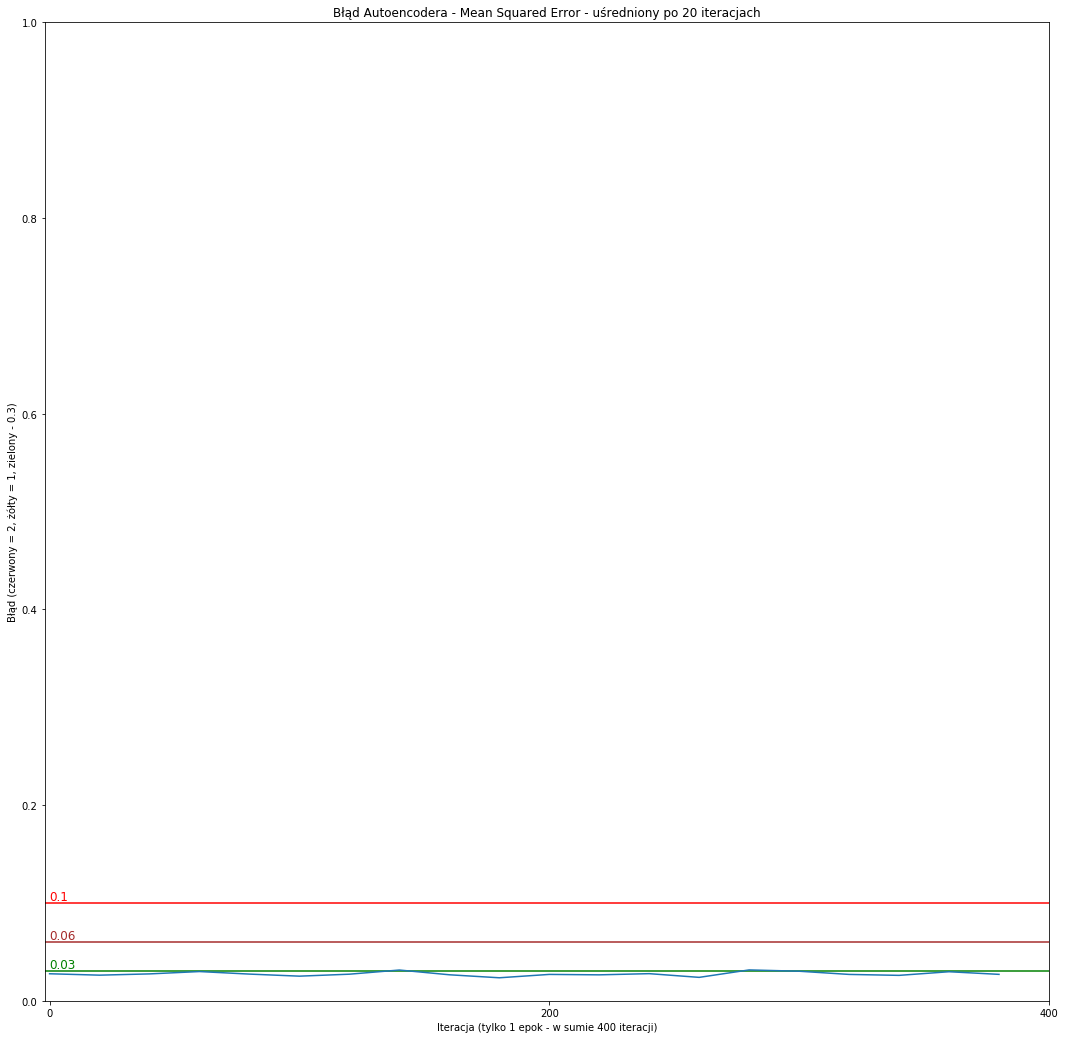

In [14]:
#Wynikowy set - błąd
fig, ax=plt.subplots(1, 1, figsize=(18,18))
#dt - liczba iteracji, kgbo - uśrednienie błędu po tylu iteracjach, ss- parametr labeli
dt=iterr
kgbo=20
dt2=dt//kgbo
ss=10

#Formulacja średnich
dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(ggout[i*kgbo:(i+1)*kgbo])/kgbo

alpha, beta, gamma=0.1,0.06,0.03

ax.set_title('Błąd Autoencodera - Mean Squared Error - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko {} epok - w sumie {} iteracji)'.format(epokz, dt))
ax.set_xticklabels(range(0, dt+1, kgbo*ss))
ax.set_xticks(range(0, dt//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1, zielony - 0.3)')
ax.axhline(alpha, color='red')
ax.axhline(beta, color='brown')
ax.axhline(gamma, color='green')
ax.plot(dkkk)
ax.text(x=0, y=alpha, s='{}'.format(alpha), verticalalignment='bottom', horizontalalignment='left', color='red', size=12)
ax.text(x=0, y=beta, s='{}'.format(beta), verticalalignment='bottom', horizontalalignment='left', color='brown', size=12)
ax.text(x=0, y=gamma, s='{}'.format(gamma), verticalalignment='bottom', horizontalalignment='left', color='green', size=12)
ax.set_ylim(0, 1)
ax.set_xlim(-0.1, dt2)
plt.show()

In [22]:
print(bias_delta)
print(sum(sdel)[0,0])

[-0.04760082662278464, 0.46436947120738, 10.82956218440274, 137.97111577949357, 0, 0, 0, 0, 0, 0]
-0.04760082662278464


In [50]:
print(math.tanh(2))

0.9640275800758169


In [36]:
kakapo=np.matrix([[100,1,2],[3,4,5],[6,7,8]])
times_of_grace=np.diag(np.sqrt(kakapo))
print(nn_delta/(times_of_grace*np.identity(3)+0.0000001))

[[9.99999990e-05 1.00000000e+04 1.00000000e+04]
 [1.00000000e+04 4.99999975e-04 1.00000000e+04]
 [1.00000000e+04 1.00000000e+04 3.53553378e-04]]


In [23]:
kakapo=np.matrix([[100,1,2],[3,4,5],[6,7,8]])
kakapo2=np.matrix([[100,1,2],[3,4,5],[6,7,8]])
print(np.multiply(kakapo, kakapo2))

[[10000     1     4]
 [    9    16    25]
 [   36    49    64]]


In [96]:
print((sum(summerland[1]<10000)))

[[20 20  4 20 20 20  1 14 20 13 17 20 14 18  5 18 15  9 20  1 20 11 12 17
  14 17 11 10  4  3  3 20 18  8 15 20  1 11  9 20 20 15 19  5 20 14 14 20
  18 17]]
